# GMM component extraction

## Load dependencies

In [1]:
import os
from glob import glob
from joblib import dump, load
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
%matplotlib inline

## Define functions to calculate the slice depth, plot the slices and calculate and plot the component frequencies

In [2]:
def add_depths(depths):
    # copy first file
    out = depths[0]
    for depth in depths[1:]:
        out = np.concatenate([out,depth+out[-1]])
    return out

def plot_sample_stack(stack, rows=4, cols=4, start_with=0, show_every=120, col_map= 'gray',roi = False,bboxes = None):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        im = ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap= col_map)
        if roi and bboxes[ind] != None:
            y_min,x_min,y_max,x_max = bboxes[ind]
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,fill=False,color = 'r')
            ax[int(i/rows),int(i % rows)].add_patch(rect)
        #ax[int(i/rows),int(i % rows)].axis('off')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    

def longcore_comp_frequency(labels,comp_names,exclude_comp = []):
    # get number of components in labels
    n_comp = len(comp_names)
    # count the number of pixels of each component per slice
    comp_freq = pd.DataFrame()
    for comp in comp_names:
        comp_freq[comp_names[comp]] = np.sum(labels==comp,axis = (1,2))
    # exclude certain components
    if len(exclude_comp)!=0:
         comp_freq = comp_freq.drop(columns = [comp_names[comp] for comp in exclude_comp])
    # divide by sum on number of components
    return comp_freq.div(comp_freq.sum(axis = 1), axis = 0)

def plot_longcore_components(frequency_table,labels,cutting_plane = 100,cmap = 'Paired'):
    n_comp = len(np.unique(labels))
    # plot
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[20, 5])
    # define colormap
    # color_map = discrete_cmap(n_comp,cmap)
    ax[0].imshow(labels[:,:,cutting_plane].T,cmap = color_map)
    ax[1].set_prop_cycle(color = color_map(range(n_comp)))
    for component in frequency_table:
        ax[1].plot(frequency_table[component], label = component)
    ax[1].set_ylabel('Relative Frequency')
    ax[1].set_xlabel('Slice No.')
    ax[1].margins(0,0)
    ax[1].legend(loc = 'upper center',bbox_to_anchor = (0.5,-0.05), ncol = n_comp//2)
    fig.tight_layout()


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #return base.from_list(cmap_name, color_list, N)
    return plt.cm.get_cmap(base_cmap, N)

## Load data

In [3]:
## ../../Documents/Projects/CT_data_Vandorpe/
data_dir = '../CT_data_Vandorpe/preproc'
model_dir = 'script_ouput/EM_models'
data_table_dir = 'script_ouput/data_tables'
label_data_dir = '../CT_data_Vandorpe/labelled_data'

In [4]:
cores = os.listdir(data_dir)
# store data per core in a dictionnary
slices = {}
data_table = {}
for core in cores:
    slice_files = glob(data_dir +'/'+ core+'/*_slices.npy')
    depth_files = glob(data_dir +'/'+ core+'/*_depths.npy')
    slices[core] = np.concatenate([np.load(f) for f in slice_files])
    data_table[core] = pd.DataFrame(add_depths([np.load(f) for f in depth_files]),
                                    columns=['Depth_mm'])

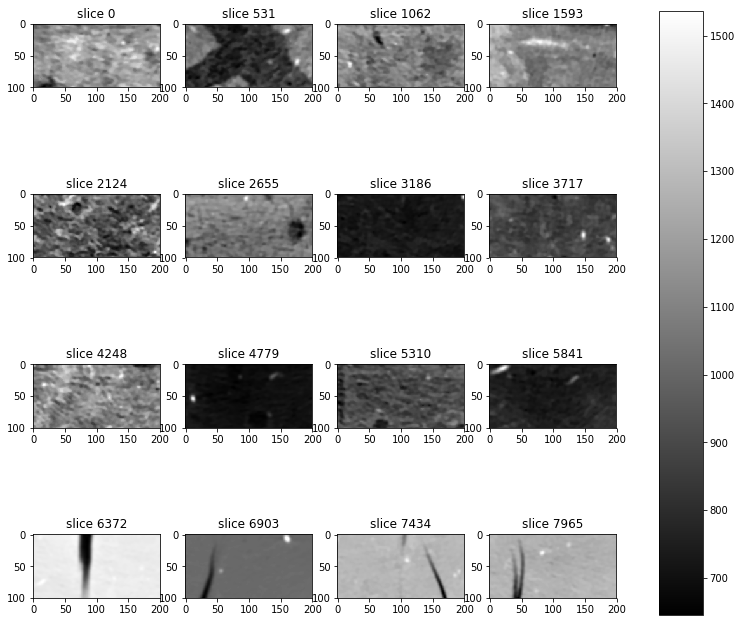

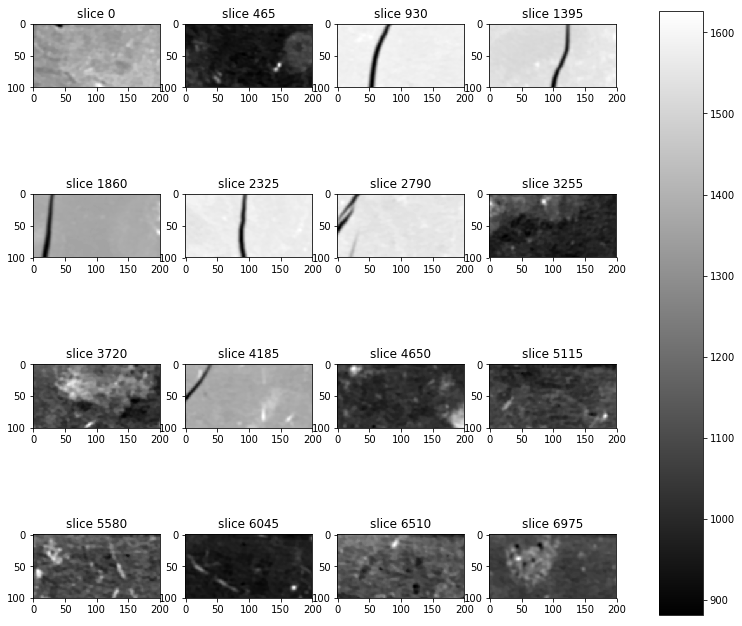

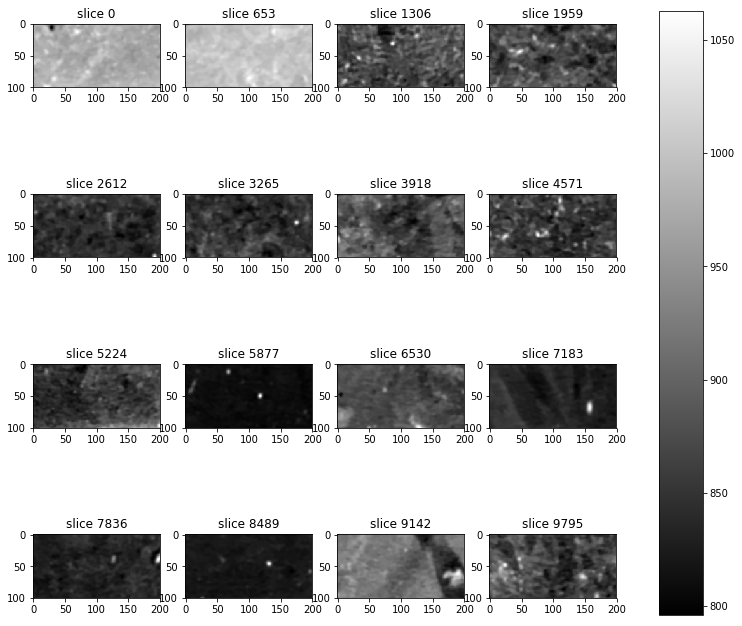

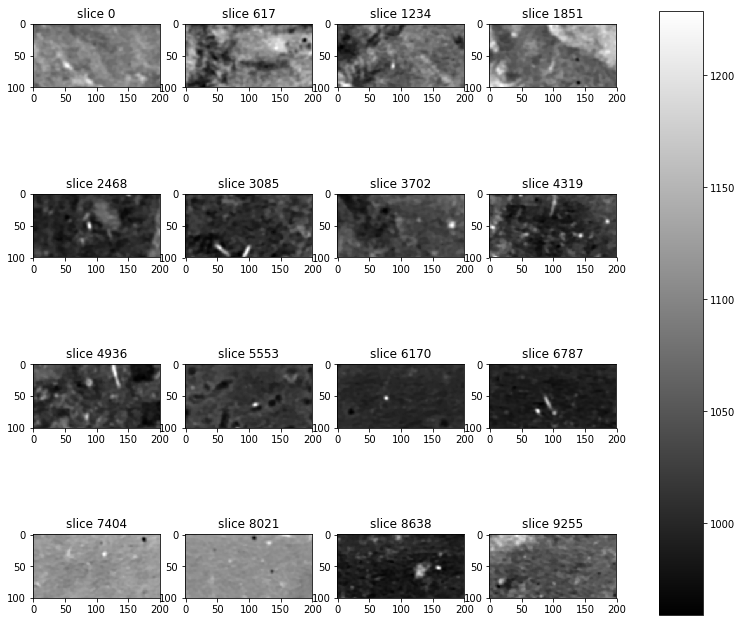

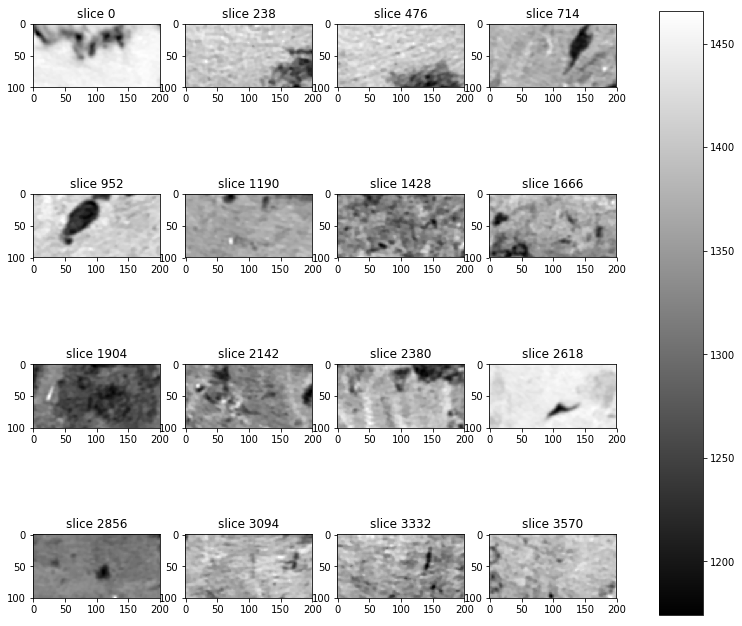

In [5]:
# plot to see if it is corretly loaded
for core in cores:
    plot_sample_stack(slices[core], show_every=slices[core].shape[0]//16)

## Collect statistics on HU distribution in each slice

In [6]:
for core in cores:
    z,y,x = slices[core].shape
    data_table[core]['Mean_HU'] = slices[core].mean(axis = (1,2))
    data_table[core]['STD_HU'] = slices[core].std(axis = (1,2))
    data_table[core]['Skewness'] = skew(slices[core].reshape((z,x*y)), axis = 1)
    data_table[core]['Kurtosis'] = kurtosis(slices[core].reshape((z,x*y)), axis = 1)

## Load models

In [7]:
pool_model, pool_model_names = load(model_dir + '/optim_pool.joblib')
core_models, core_models_names = load(model_dir + '/optim_core_models.joblib')

## Label data with models, calculate statistics, output labelled data and data table

In [8]:
for core in cores:
    print('Processing Core: ' + core)
    z,y,x = slices[core].shape
    # get probabilities for the pool model
    probs = pool_model.predict_proba(slices[core].reshape(-1,1))
    # get the component number with maximal probability
    labels_pool_model = probs.argmax(axis = 1).reshape((z,y,x))
    # get the misclassification probability
    misclas_pool_model = (1-probs.max(axis = 1)).reshape((z,y,x))
    # get probabilities for the core models
    probs = core_models[core].predict_proba(slices[core].reshape(-1,1))
    # get the component number with maximal probability
    labels_core_models = probs.argmax(axis = 1).reshape((z,y,x))
    # get the misclassification probability
    misclas_core_models = (1-probs.max(axis = 1)).reshape((z,y,x))
    # calculate component frequencies for both models and add them to the data table
    data_table[core] = pd.concat([data_table[core],
                                  longcore_comp_frequency(labels=labels_pool_model,
                                                          comp_names=pool_model_names).add_suffix('_pool'),
                                  pd.Series(misclas_pool_model.mean(axis = (1,2)), name = 'Misclas_prob_pool'),
                                  longcore_comp_frequency(labels=labels_core_models,
                                                         comp_names=core_models_names[core]).add_suffix('_core'),
                                  pd.Series(misclas_core_models.mean(axis = (1,2)), name = 'Misclas_prob_core')],
                                 axis = 1)
    # dump the pool and core models and data table before they get overwritten in next iteration
    data_table[core].to_csv(data_table_dir + '/' + core + '.csv')
    dump(labels_pool_model, label_data_dir+ '/' + core + '_pool.joblib')
    dump(labels_core_models, label_data_dir+ '/' + core + '_core.joblib')
    dump(misclas_pool_model, label_data_dir+ '/' + core + '_pool.joblib')
    dump(misclas_core_models, label_data_dir+ '/' + core + '_core.joblib')

Processing Core: GC01
Processing Core: K3
Processing Core: M08
Processing Core: M15
Processing Core: PC06
